In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

In [4]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [6]:
char2int_smb = { 
    "X": 0,  # smb unpassable
    "S": 1,  # smb breakable
    "-": 2,
    "?": 3,  # smb question
    "Q": 4,  # smb question
    "E": 5,
    "<": 6,
    ">": 7,
    "[": 8,
    "]": 9,
    "o": 10,
    "P": 11,  # for smb path (from Anurag's email)
}
int2char = {v:k for k, v in char2int_smb.items()}
char2name = {
    'X': 'unpassable',
    'S': 'breakable',
    '-': 'background',
    '?': 'SMB question',
    'Q': 'SMB question',
    'E': 'SMB enemy',
    '<': 'Top-left pipe element',
    '>': 'Top-right pipe element',
    '[': 'Bottom-left pipe element',
    ']': 'Bottom-right pipe element',
    'o': 'Coins',
    'P': 'Player path'
}

## Density

In [7]:
RESULTS_DIR = '/home/yangz2/projects/gmvae_and_gmmvae/results'
GAME = 'smba'
MODEL = 'gmvae'
num_components=10

In [8]:
json_fname = f'{RESULTS_DIR}/{GAME}_{MODEL}_generations/{GAME}_{MODEL}_{num_components}.json'
num_components = int(json_fname.split('_')[-1].split('.')[0])
num_gens_per_comp = 500

In [9]:
chunks_int = open_json_as_nparray(json_fname)
begin, end = 0, num_gens_per_comp
chunks_by_comp = []
for i in range(num_components):
    chunks_by_comp.append(chunks_int[begin:end])
    begin, end = begin + num_gens_per_comp, end + num_gens_per_comp

In [10]:
def get_densities(chunks):
    unique_indices = np.unique(chunks)
    densities = {i:[] for i in unique_indices}
    for idx, chunk in enumerate(chunks):
        for i in unique_indices:
            chunk_mod = chunk == i
            densities[i].append(np.count_nonzero(chunk_mod))
    return [np.mean(v) for k, v in densities.items()]

In [11]:
densities_by_comp = [get_densities(chunks) for chunks in chunks_by_comp]
len(densities_by_comp)

10

In [30]:
df = pd.DataFrame(densities_by_comp)
df = df.fillna(0)
# df /= df.max()
df.columns = [int2char[i] for i in np.unique(chunks_int)]
df = df.iloc[:,:-1]
df.head(10)

,X,S,-,?,Q,E,<,>,[,],o
0,13.356,1.438,220.932,0.094,0.070,0.078,0.048,0.048,0.154,0.138,1.730
1,17.722,1.512,212.822,0.056,0.060,0.458,0.754,0.758,1.802,1.710,0.814
2,16.026,0.938,221.268,0.134,0.874,0.258,0.104,0.100,0.004,0.196,16.098
3,40.102,1.780,195.094,0.060,0.072,0.298,0.300,0.286,0.664,0.640,0.172
4,20.860,4.094,205.530,0.076,0.090,0.602,0.934,0.964,2.218,2.178,0.274
5,24.148,1.596,209.896,0.058,0.234,0.368,0.366,0.390,0.682,0.660,0.142
6,15.936,22.086,195.942,0.244,0.228,0.668,0.330,0.284,0.974,0.962,2.066
7,14.638,0.886,219.816,0.102,0.104,0.184,0.230,0.244,0.586,0.566,0.930
8,14.640,0.854,221.930,0.052,0.272,0.278,0.212,0.210,0.198,0.234,0.526
9,17.382,4.952,211.792,0.154,0.740,0.462,0.484,0.498,0.942,0.940,0.410


In [47]:
df = df.drop(['-'], axis=1)

In [48]:
tilenames = list(df)

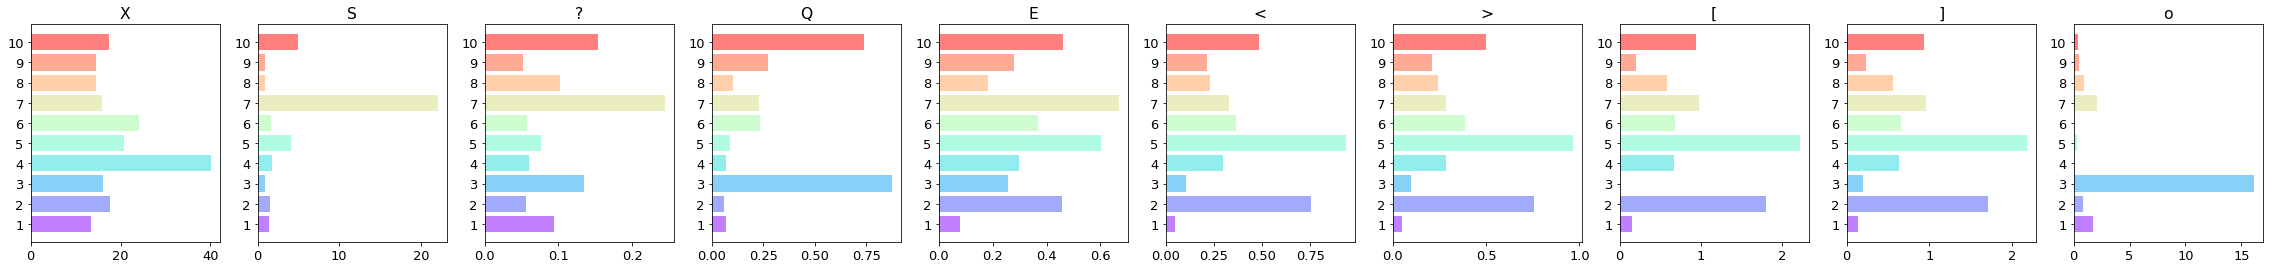

In [57]:
num_plots = len(tilenames)
num_rows = 1
num_cols = num_plots // num_rows

plt.rcParams.update({'font.size': 13})

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 4, num_rows * 4))
if num_rows == 1:
    axs = [axs]

colors=plt.cm.rainbow(np.linspace(0,1,num_components))

for row_ix in range(num_rows):
    for col_ix in range(num_cols):
    
        index = row_ix * num_cols + col_ix
    
        axs[row_ix][col_ix].barh(np.arange(1, num_components + 1), df.iloc[:, index], 
                                 color=colors, alpha=0.5)
        axs[row_ix][col_ix].set_title(tilenames[index])
        
        axs[row_ix][col_ix].set_yticks(np.arange(1, num_components + 1))
    
plt.savefig("tilewise_barplot.png", dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Plotting generations from each component

In [77]:
import sys
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

In [78]:
def get_images(chunks_int):
    images = []
    for chunk in chunks_int:
        images.append(vglc_with_path_encodings.array_to_image([chunk], game='smba')[0])
    return images

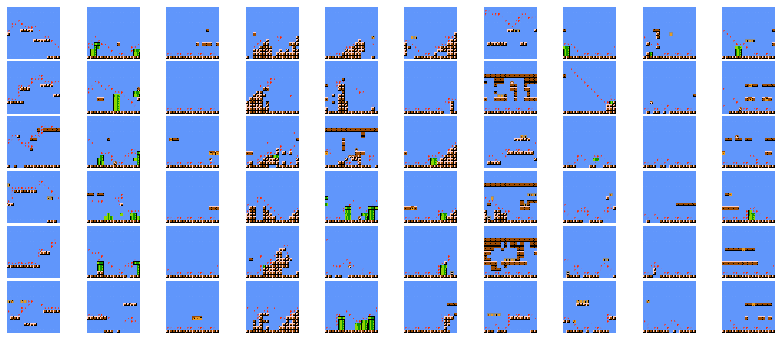

In [86]:
num_rows=6
fig, axs = plt.subplots(num_rows, num_components, figsize=(num_components+4, num_rows))
fig.subplots_adjust(hspace=0.05)
# plt.suptitle('SMB', fontsize=50, y=0.915)
for comp_idx, chunks in enumerate(chunks_by_comp):
    imgs = get_images(chunks[:num_rows])
    for img_idx, img in enumerate(imgs):
        if img_idx == 1:
            pass
#             ax.set_ylabel(f'{comp_idx + 1}', rotation=0, fontsize=50)
            # https://stackoverflow.com/questions/27671748/how-to-print-y-axis-label-horizontally-in-a-matplotlib-pylab-chart
#             ax.yaxis.set_label_coords(-0.5, 0.15)
            # https://stackoverflow.com/questions/37815976/setting-the-position-of-the-ylabel-in-a-matplotlib-graph
        ax = axs[img_idx][comp_idx]
#         if comp_idx == 0 and img_idx == 2:
#             ax.set_ylabel('SMB', fontsize=20)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
# plt.tight_layout()
plt.savefig(f'SMB generations per component (GM-VAE {num_components}).png', dpi=600)